In [220]:
import pandas as pd
import numpy as np

In [221]:
fish=pd.read_csv("http://bit.ly/fish_csv_data")

In [222]:
fish.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159 entries, 0 to 158
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Species   159 non-null    object 
 1   Weight    159 non-null    float64
 2   Length    159 non-null    float64
 3   Diagonal  159 non-null    float64
 4   Height    159 non-null    float64
 5   Width     159 non-null    float64
dtypes: float64(5), object(1)
memory usage: 7.6+ KB


## target 과 feature 살펴보기

### target

In [223]:
fish["Species"].value_counts()

Species
Perch        56
Bream        35
Roach        20
Pike         17
Smelt        14
Parkki       11
Whitefish     6
Name: count, dtype: int64

### target 변환

In [224]:
# 이진분류를 위한 데이터 부분 추출
idx=(fish["Species"]=='Bream')|(fish["Species"]=='Smelt')
use_df=fish[idx]

In [225]:
import statsmodels.api as sm
import scipy as sp
import numpy as np

### 데이터 확인, 전처리 및 시각화

In [226]:
use_df.describe()

,Weight,Length,Diagonal,Height,Width
count,49.000000,49.000000,49.000000,49.000000,49.000000
mean,444.500000,27.055102,31.120408,11.476400,4.259751
std,328.143233,10.242804,12.097296,6.150976,1.967686
min,6.700000,9.800000,10.800000,1.728400,1.047600
25%,19.700000,14.300000,15.200000,2.872800,1.879200
50%,500.000000,31.000000,36.200000,14.179500,5.072800
75%,700.000000,34.500000,39.700000,15.633000,5.589000
max,1000.000000,41.000000,46.500000,18.957000,6.749700


weight의 최대값이 너무 큼 -> 데이터간 크기가 크게 다를수있음

In [227]:
import matplotlib.pyplot as plt
import seaborn as sb

#### 이상치

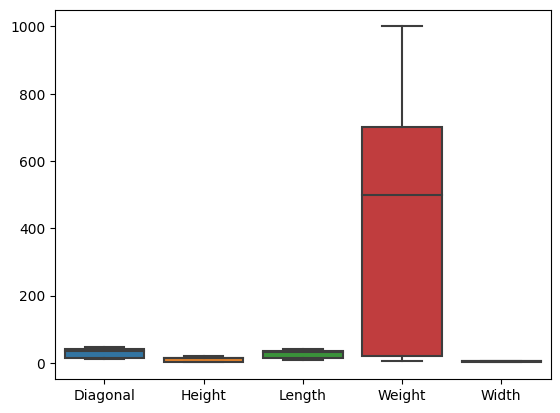

In [228]:
plt.figure()
sb.boxplot(use_df[use_df.columns.difference(["Species"])])
plt.show()

이상치는 발견되지않았으므로 scaling을 통해 데이터간 크기를 조정해주면 될듯

In [229]:
import sklearn.preprocessing as skpre
import sklearn.model_selection as skmod

#### 변수간 다중공선성 검사

In [230]:
vif=[]
features=use_df.columns.difference(["Species"])
for feature in features:
    temp=sm.OLS(endog=use_df[feature],exog=use_df[[col for col in features if col!=feature]]).fit()
    r=temp.rsquared
    vif.append({'feature':feature,'vif':1/(1-r)})

In [231]:
pd.DataFrame(vif)

,feature,vif
0,Diagonal,15318.131539
1,Height,550.413611
2,Length,11811.799109
3,Weight,60.011258
4,Width,424.189685


위에서 보았다시피 다중공선성 위험이 너무 높은 feature들이므로 이 부분을 해결해야함

- 1. 다중공선성이 10을 넘어가지 않게 feature를 제거
- 2. 요인적재값을 이용한 feature selection
- 3. PCA를 이용한 차원축소

#### 요인적재값을 이용한 feature selection

In [232]:
import numpy as np

PCA 부터 해야겠지?

In [233]:
cov_matrix=use_df[features].corr(method="pearson")

In [234]:
eigen_values,eigen_vectors=np.linalg.eig(cov_matrix)

In [235]:
result=pd.DataFrame(zip([f'제 {i+1}성분' for i in range(len(eigen_values))],eigen_values/sum(eigen_values)))
result.rename(columns={0:'주성분',1:'eigen_values'},inplace=True)
result

,주성분,eigen_values
0,제 1성분,0.982584
1,제 2성분,0.013709
2,제 3성분,0.000057
3,제 4성분,0.002289
4,제 5성분,0.001361


In [236]:
pca=use_df[features]@eigen_vectors[:2].T
pca.rename(columns={0:'제 1주성분',1:'제 2주성분'},inplace=True)

In [237]:
pca.head(3)

,제 1주성분,제 2주성분
0,120.086947,2.199575
1,138.905788,1.889450
2,157.643868,1.279830


제 1주성분과 제 2주성분을 이용할 경우, 전체 분산의 99%이상을 표현하므로 2개의 주성분을 이용하겠음

CFA

In [238]:
cfa=np.linalg.lstsq(pca,use_df[features],rcond=None)

In [239]:
cfa_result=pd.DataFrame(cfa[0]).T.rename(columns={0:'제 1주성분',1:'제 2주성분'}).rename(dict(zip(range(len(features)),features)))
cfa_result.abs().sort_values(by="제 1주성분",ascending=False).style.background_gradient(cmap="PuBu")

,제 1주성분,제 2주성분
Weight,2.359804,15.334535
Diagonal,0.122793,5.276380
Length,0.106109,4.659031
Height,0.051101,1.124713
Width,0.017943,0.547709


위의 결과를 토대로 weight가 압도적으로 많은 정보량을 가졌으나,지나치게 많은 변수를 제거할수 없다고 판단하여 두개의 변수를 선택

In [240]:
final_features=["Weight","Diagonal"]

In [241]:
vif=[]
for feature in final_features:
    temp=sm.OLS(endog=use_df[feature],exog=use_df[[col for col in final_features if col!=feature]]).fit()
    r=temp.rsquared
    vif.append({'feature':feature,'vif':1/(1-r)})

In [242]:
pd.DataFrame(vif)

,feature,vif
0,Weight,11.509532
1,Diagonal,11.509532


#### minmax scale

In [243]:
use_df[use_df.columns.difference(["Species"])]=skpre.minmax_scale(use_df[use_df.columns.difference(["Species"])])

C:\Users\User\AppData\Local\Temp\ipykernel_1260\494444351.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_df[use_df.columns.difference(["Species"])]=skpre.minmax_scale(use_df[use_df.columns.difference(["Species"])])


#### LogisticRegression을 위한 종속변수의 encoding
> `Bream`을 1로 변환, 당연히 나머진 0

In [244]:
use_df["Species"]=use_df["Species"].apply(lambda x:1 if x=="Bream" else 0)

C:\Users\User\AppData\Local\Temp\ipykernel_1260\3404938866.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_df["Species"]=use_df["Species"].apply(lambda x:1 if x=="Bream" else 0)


### 데이터 분리

In [245]:
train,test=skmod.train_test_split(use_df,train_size=0.8,stratify=use_df['Species'],random_state=10)

데이터 수가 적으므로 층화추출을 통해 불균형한 학습 방지

In [246]:
logit_model=sm.Logit(endog=train["Species"],exog=train[final_features]).fit()

         Current function value: 0.000000
         Iterations: 35


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [247]:
logit_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                Species   No. Observations:                   39
Model:                          Logit   Df Residuals:                       37
Method:                           MLE   Df Model:                            1
Date:                Wed, 20 Sep 2023   Pseudo R-squ.:                   1.000
Time:                        16:24:48   Log-Likelihood:            -6.7970e-07
converged:                      False   LL-Null:                       -23.200
Covariance Type:            nonrobust   LLR p-value:                 9.638e-12
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Weight      1691.5831   1.37e+05      0.012      0.990   -2.66e+05     2.7e+05
Diagonal    -712.4856   5.88e+04     -0.012      0.990   -1.16e+05    1.15e+05
==============================================================================

Complete Separation: The results show that there iscomplete separation or perfect prediction.
In this case the Maximum Likelihood Estimator does not exist and the parameters
are not identified.
"""

#### 학습결과

In [250]:
logit_model.pred_table()

array([[11.,  0.],
       [ 0., 28.]])

In [258]:
pred_result=logit_model.predict(test[final_features])
test_result=pd.merge(test["Species"],pd.DataFrame(pred_result),right_index=True,left_index=True).rename(columns={0:'predict'})
test_result["predict"]=test_result["predict"].apply(lambda x:1 if x>0.5 else 0)
test_result

,Species,predict
24,1,1
33,1,1
8,1,1
1,1,1
11,1,1
145,0,0
26,1,1
154,0,0
149,0,0
16,1,1


검증 데이터의 confussion matrix

In [263]:
pd.crosstab(columns=test_result["predict"],index=test_result["Species"])

predict,0,1
Species,,
0,3,0
1,0,7
